# Domains reputation

## Get data

In [1]:
import json
import pickle
import sys
import gaffer
import threatgraph
from tabulate import tabulate
import time
import hashlib
import pandas as pd
import math
import matplotlib.pyplot as plt
import whois_db
import numpy as np
import datetime

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

### Matches

In [3]:
matches = pickle.load(open("cache.MATCH", "rb"))
blacklist = pickle.load(open("cache.BLACKLIST", "rb"))

In [4]:
############################################################################
# Collapsing blacklists.
############################################################################

# A func which maps a blacklist name to its shorter form throws away all after the dot.
def make_sbl(x):
    a = x.split(".")
    return a[0]

# Map all blacklists to shorter form.  This should return: apility, facebook, vt.
sbls=[make_sbl(v) for v in blacklist]
sbls=sorted(set(sbls))

# Return a column name to number map
sbls_ix={sbls[i]: i for i in range(0, len(sbls))}

In [5]:
sbls

['apility', 'facebook', 'vt']

In [6]:
sbls_ix

{'apility': 0, 'facebook': 1, 'vt': 2}

### Gaffer query for domains

In [7]:
############################################################################
# Fetch device -> IP -> DNS query -> domain edges
############################################################################

op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()

url = "/rest/v2/graph/operations/execute/chunked"

res = g.execute_chunked(op)


### Convert to variety of data structures

In [8]:
############################################################################
# Process graph output, construct a variety of maps.
############################################################################

# Maps domain to timestamp buckets
timestamps = {}

# Maps domain to counts
counts = {}

# Maps (device,domain) -> True
doms = {}

# All domains
all_domains = set()

# All devices
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    domain = list(ent["entities"][3].keys())[0]
    k = (dev, domain)

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    if not domain in counts:
        counts[domain] = 0
        timestamps[domain] = set()

    counts[domain] += cnt
    timestamps[domain].update(ts)
    doms[k] = True
    
    all_domains.add(domain)
    all_devices.add(dev)

all_domains = list(all_domains)
all_devices = list(all_devices)

In [9]:
############################################################################
# Work out the earliest and latest timestamps.
############################################################################

smallest=None
largest=None
for v in timestamps:

    if smallest == None:
        smallest = min(timestamps[v])
    else:
        smallest = min(smallest, min(timestamps[v]))

    if largest == None:
        largest = max(timestamps[v])
    else:
        largest = max(largest, max(timestamps[v]))

print(smallest, largest)


1527238800.0 1532120400.0


## Construct reputation vector

In [10]:
############################################################################
# Construct domain vector:
#   device, domain, earliest timestamp, latest, largest gap, blacklists..., devices...
############################################################################

# This has true/false elements for whether a device has interacted with a domain or not.

# Takes a timestamp set and returns the largest distance between two adjacent
# elements.

def gap(s):
    last = min(s)
    gap = 0
    for v in sorted(s):
        gap = max(gap, v - last)
        last = v
    return gap

datas = []

for v in counts:

    domain = v
    tss = timestamps[v]
    cnt = counts[v]
    tss2 = tss.union(set([smallest, largest]))
    biggest_gap = gap(tss2)

    data = [domain, min(tss), max(tss), biggest_gap, cnt, 0, 0, 0]
    
    blacks = [0.0 for i in range(0, len(sbls))]
        
    if domain in matches:

        for v2 in matches[domain]:
            
            bl = v2["blacklist"]
            sbl = make_sbl(bl)
            thing_latest = v2["latest"]
            source = blacklist[bl]["source"]
            blocklist_latest = blacklist[bl]["latest"]
            prob = blacklist[bl]["probability"]

            blocklist_decay_period = 86400 * 360
            blocklist_age = time.time() - blocklist_latest
            blocklist_factor = blocklist_decay_period - blocklist_age
            blocklist_factor /= blocklist_decay_period
            if blocklist_factor < 0: blocklist_factor = 0

            thing_decay_period = 86400 * 28
            thing_age = time.time() - thing_latest
            thing_factor = thing_decay_period - thing_age
            thing_factor /= thing_decay_period
            if thing_factor < 0: thing_factor = 0
            
            prob = prob * thing_factor * blocklist_factor

            prob = 1.0 - ((1.0 - blacks[sbls_ix[sbl]]) * (1.0 - prob))
            blacks[sbls_ix[sbl]] = prob

    data = data + blacks
    
    for dev in all_devices:
        if (dev, domain) in doms:
            data.append(1)
        else:
            data.append(0)
    
    datas.append(data)

In [11]:
cols = ["domain", "first", "last", "gap", "count", "devices", "created", "updated"] + sbls + all_devices
df = pd.DataFrame(datas, columns=cols)

df = df.set_index(["domain"])

In [12]:
df["devices"] = df[all_devices].sum(axis=1)

In [13]:
# Now have domain, first and last observation and whether or not a device has used it.
df

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,essential-cb,turing-macbook,MalcomWare-PC,dgmac,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac
domain,,,,,,,,,,,,,,,,,,,,,
doubleclick.net,1.528207e+09,1.532120e+09,968400.0,26422,36,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
gstatic.com,1.528204e+09,1.532120e+09,964800.0,55410,37,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
in-addr.arpa,1.528207e+09,1.532120e+09,968400.0,43332,27,0,0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,0,1,1
geiusdanb.openvpn,1.531213e+09,1.531213e+09,3974400.0,2,1,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
google.com,1.527239e+09,1.532120e+09,439200.0,310121,37,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
metadsp.co.uk,1.528214e+09,1.532106e+09,975600.0,100,16,0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,1
msecnd.net,1.528207e+09,1.532095e+09,968400.0,942,23,0,0,0.0,0.0,0.0,...,0,0,1,1,1,1,1,1,0,1
googleapis.com,1.527678e+09,1.532120e+09,439200.0,54128,36,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
sundaysky.com,1.529680e+09,1.531991e+09,2440800.0,33,9,0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


## Add whois data

In [14]:
whois = pickle.load(open("db.WHOIS", "rb"))

In [15]:
[(d, whois[d].created, whois[d].updated) for d in whois]

[('responsetap.com',
  datetime.datetime(2012, 10, 5, 8, 44, 22),
  datetime.datetime(2018, 4, 13, 14, 20, 52)),
 ('cbsinteractive.com',
  datetime.datetime(2006, 11, 7, 4, 6, 47),
  datetime.datetime(2017, 7, 20, 21, 6, 26)),
 ('oixnet.org',
  datetime.datetime(2013, 3, 3, 21, 45, 39),
  datetime.datetime(2018, 5, 22, 20, 25, 46)),
 ('ntent.com',
  datetime.datetime(1997, 4, 30, 4, 0),
  datetime.datetime(2018, 1, 31, 0, 56, 34)),
 ('pressdns.com',
  datetime.datetime(2010, 7, 8, 1, 45, 17),
  datetime.datetime(2018, 4, 14, 4, 15, 59)),
 ('ip-158-69-7.net',
  datetime.datetime(2015, 6, 15, 10, 52, 44),
  datetime.datetime(2018, 6, 15, 3, 49, 8)),
 ('mahalo.com',
  datetime.datetime(1995, 2, 21, 5, 0),
  datetime.datetime(2018, 2, 19, 12, 41, 11)),
 ('oembed.com',
  datetime.datetime(2008, 3, 21, 5, 19, 46),
  datetime.datetime(2018, 1, 26, 19, 59, 42)),
 ('dynapis.info',
  datetime.datetime(2015, 4, 16, 14, 39, 7),
  datetime.datetime(2018, 4, 10, 4, 10, 20)),
 ('fasttory.com',
  date

In [16]:
whois["trustnetworks.com"].created.strftime("%Y-%m-%d")

'2003-07-13'

In [17]:
whois["trustnetworks.com"].updated.strftime("%Y-%m-%d")

'2018-07-14'

In [18]:
created = lambda d: whois[d].created.timestamp() if d in whois and whois[d].created != None else None
updated = lambda d: whois[d].updated.timestamp() if d in whois and whois[d].updated != None else None

print(created("google.com"))
print(updated("google.com"))

874292400.0
1519238707.0


In [19]:
df["created"] = [created(v) for v in df.index]
df["updated"] = [updated(v) for v in df.index]

In [20]:
df

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,essential-cb,turing-macbook,MalcomWare-PC,dgmac,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac
domain,,,,,,,,,,,,,,,,,,,,,
doubleclick.net,1.528207e+09,1.532120e+09,968400.0,26422,36,8.217684e+08,1.513420e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
gstatic.com,1.528204e+09,1.532120e+09,964800.0,55410,37,1.202717e+09,1.517350e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
in-addr.arpa,1.528207e+09,1.532120e+09,968400.0,43332,27,7.806204e+08,1.528672e+09,0.0,0.0,0.0,...,0,1,0,1,0,1,0,0,1,1
geiusdanb.openvpn,1.531213e+09,1.531213e+09,3974400.0,2,1,NaN,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
google.com,1.527239e+09,1.532120e+09,439200.0,310121,37,8.742924e+08,1.519239e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
metadsp.co.uk,1.528214e+09,1.532106e+09,975600.0,100,16,1.473203e+09,1.501715e+09,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,1
msecnd.net,1.528207e+09,1.532095e+09,968400.0,942,23,1.222726e+09,1.506313e+09,0.0,0.0,0.0,...,0,0,1,1,1,1,1,1,0,1
googleapis.com,1.527678e+09,1.532120e+09,439200.0,54128,36,1.106676e+09,1.514111e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
sundaysky.com,1.529680e+09,1.531991e+09,2440800.0,33,9,1.147703e+09,1.519237e+09,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


## Scoring device based on when the domain was first accessed

In [21]:
# Calculate the number of hours since domain first seen in use.
decay = 86400
df["age"] = (time.time() - df["first"]) / decay

In [22]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.

df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)

In [23]:
df.sort_values("devices", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,MalcomWare-PC,dgmac,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac,age,score
domain,,,,,,,,,,,,,,,,,,,,,
gstatic.com,1.528204e+09,1.532120e+09,964800.0,55410,37,1.202717e+09,1.517350e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,45.365646,0.0
google.com,1.527239e+09,1.532120e+09,439200.0,310121,37,8.742924e+08,1.519239e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,56.532312,0.0
doubleclick.net,1.528207e+09,1.532120e+09,968400.0,26422,36,8.217684e+08,1.513420e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,45.323979,0.0
googleapis.com,1.527678e+09,1.532120e+09,439200.0,54128,36,1.106676e+09,1.514111e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,51.448979,0.0
google-analytics.com,1.528207e+09,1.532120e+09,968400.0,6686,36,1.121666e+09,1.529138e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,45.323979,0.0
googleusercontent.com,1.528207e+09,1.532120e+09,968400.0,19661,36,1.226938e+09,1.517350e+09,0.0,0.0,0.0,...,0,1,1,1,1,1,1,1,45.323979,0.0
youtube.com,1.528207e+09,1.532120e+09,968400.0,2319,35,1.108444e+09,1.517350e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,45.323979,0.0
amazonaws.com,1.528207e+09,1.532120e+09,968400.0,22726,34,1.124327e+09,1.520545e+09,0.0,0.0,0.0,...,0,1,1,1,1,1,1,1,45.323979,0.0
googletagmanager.com,1.528207e+09,1.532120e+09,968400.0,1498,33,1.321055e+09,1.507624e+09,0.0,0.0,0.0,...,0,0,1,1,1,1,1,1,45.323979,0.0


In [24]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [25]:
df2.sort_values("devices", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,MalcomWare-PC,dgmac,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac,age,score
domain,,,,,,,,,,,,,,,,,,,,,
gstatic.com,1.528204e+09,1.532120e+09,964800.0,55410,37,1.202717e+09,1.517350e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.365646,0.0
google.com,1.527239e+09,1.532120e+09,439200.0,310121,37,8.742924e+08,1.519239e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.532312,0.0
doubleclick.net,1.528207e+09,1.532120e+09,968400.0,26422,36,8.217684e+08,1.513420e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0
googleapis.com,1.527678e+09,1.532120e+09,439200.0,54128,36,1.106676e+09,1.514111e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.448979,0.0
google-analytics.com,1.528207e+09,1.532120e+09,968400.0,6686,36,1.121666e+09,1.529138e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0
googleusercontent.com,1.528207e+09,1.532120e+09,968400.0,19661,36,1.226938e+09,1.517350e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0
youtube.com,1.528207e+09,1.532120e+09,968400.0,2319,35,1.108444e+09,1.517350e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0
amazonaws.com,1.528207e+09,1.532120e+09,968400.0,22726,34,1.124327e+09,1.520545e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0
googletagmanager.com,1.528207e+09,1.532120e+09,968400.0,1498,33,1.321055e+09,1.507624e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.323979,0.0


## Compute per-device score

In [26]:
score_cols = df2.columns[10:-2]
score1 = df2[score_cols].sum().to_frame("score")
score1 /= score1.max()

In [27]:
score1.sort_values(by="score", ascending=False)

,score
raymond-mac,1.000000
essential-chrome,0.279856
theatergoing-mac,0.176835
misskitty-mac,0.152950
appropriate-android,0.143741
minesweepers-mac,0.138129
turing-minimacbook,0.116978
tirasse-mac,0.112950
boundless-mac,0.094676
calcannea-android,0.085755


In [28]:
def func(data):
    p = 1.0
    for v in data:
        p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [29]:
score2.sort_values("score", ascending=False)

,score
boundless-mac,1.00
calcannea-cb,1.00
minesweepers-mac,1.00
turing-minimacbook,1.00
raymond-mac,1.00
tirasse-mac,1.00
steamverne-mac,1.00
dramatic-mac,1.00
misskitty-mac,1.00
essential-chrome,1.00


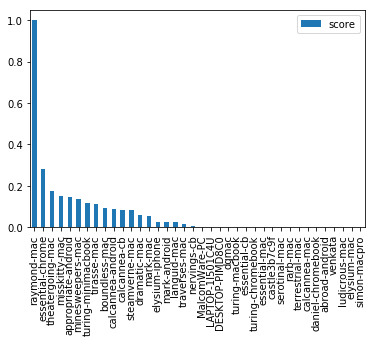

In [30]:
plt.figure(figsize=(20, 30))
score1.sort_values("score", ascending=False).plot.bar()
plt.show()

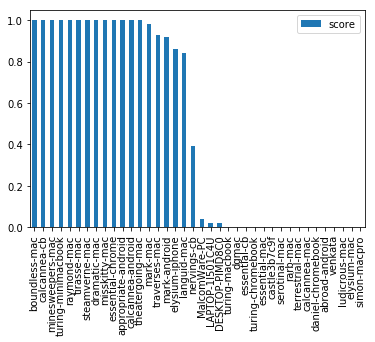

In [31]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()

## Same thing but reduce score if more devices access that domain

In [32]:
# Calculate the number of hours since domain first seen in use.
df["age"] = (time.time() - df["first"]) / decay

In [33]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.
# Difference here is that score is reduced with higher device count.
df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)
df["score"] /= 2 ** df["devices"]

In [34]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [35]:
score1 = df2[score_cols].sum().to_frame("score")
score1 /= score1.max()

In [36]:
score1.sort_values(by="score", ascending=False)

,score
raymond-mac,1.000000
essential-chrome,0.275379
theatergoing-mac,0.171318
misskitty-mac,0.143989
appropriate-android,0.138267
minesweepers-mac,0.132942
turing-minimacbook,0.116245
tirasse-mac,0.110379
boundless-mac,0.091372
calcannea-android,0.085415


In [37]:
def func(data):
    p = 1.0
    for v in data:
        p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [38]:
score2.sort_values("score", ascending=False)

,score
raymond-mac,1.00
appropriate-android,1.00
essential-chrome,1.00
theatergoing-mac,1.00
misskitty-mac,1.00
turing-minimacbook,0.99
minesweepers-mac,0.99
tirasse-mac,0.98
calcannea-cb,0.98
steamverne-mac,0.97


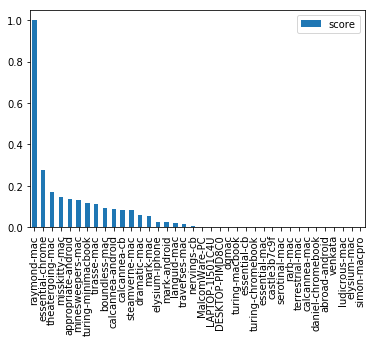

In [39]:
plt.figure(figsize=(20, 30))
score1.sort_values("score", ascending=False).plot.bar()
plt.show()

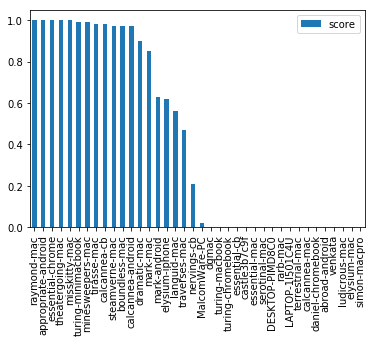

In [40]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()

## Age based on WHOIS data

In [41]:
# Calculate the number of hours since domain first seen in use.
decay = 86400 * 3
df["discovered"] = df[["updated","first"]].apply(min, axis=1)
df["age"] = (time.time() - df["discovered"]) / decay

In [42]:
df.sort_values("discovered", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,dgmac,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac,age,score,discovered
domain,,,,,,,,,,,,,,,,,,,,,
explainshell.com,1.532009e+09,1.532009e+09,4770000.0,1,1,1.376942e+09,1.532077e+09,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0.441334,0.1350,1.532009e+09
legacy.vg,1.532038e+09,1.532038e+09,4798800.0,1,1,NaN,1.531961e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.626323,0.1850,1.531961e+09
bsigroup.com,1.531944e+09,1.531944e+09,4705200.0,1,1,1.059016e+09,1.532062e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.691334,0.0650,1.531944e+09
vidora.com,1.531933e+09,1.532070e+09,4694400.0,8,2,1.063830e+09,1.532029e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.733001,0.0275,1.531933e+09
firesnap.net,1.532016e+09,1.532016e+09,4777200.0,2,1,1.352868e+09,1.531931e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.742414,0.1450,1.531931e+09
impressionsadv.net,1.531926e+09,1.531926e+09,4687200.0,1,1,9.957199e+08,1.532070e+09,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0.760779,0.0500,1.531926e+09
interactivedata.com,1.531901e+09,1.531901e+09,4662000.0,1,1,8.272116e+08,1.532097e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.858001,0.0400,1.531901e+09
intercontinentalexchange.com,1.531901e+09,1.531901e+09,4662000.0,1,1,9.532362e+08,1.532097e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.858001,0.0400,1.531901e+09
pin.it,1.531897e+09,1.531897e+09,4658400.0,1,1,1.093216e+09,1.532048e+09,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0.871890,0.0350,1.531897e+09


In [43]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.
df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)

In [44]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [45]:
df2["when"] = df2["discovered"].apply(lambda x: datetime.datetime.fromtimestamp(x) if not np.isnan(x) else None)
df2.sort_values("score", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,calcannea-cb,dramatic-mac,essential-chrome,appropriate-android,turing-chromebook,boundless-mac,age,score,discovered,when
domain,,,,,,,,,,,,,,,,,,,,,
explainshell.com,1.532009e+09,1.532009e+09,4770000.0,1,1,1.376942e+09,1.532077e+09,0.000000,0.0,0.0,...,0.00,0.00,0.64,0.0,0.0,0.00,0.441334,0.64,1.532009e+09,2018-07-19 15:00:00
legacy.vg,1.532038e+09,1.532038e+09,4798800.0,1,1,NaN,1.531961e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.626323,0.53,1.531961e+09,2018-07-19 01:40:51
bsigroup.com,1.531944e+09,1.531944e+09,4705200.0,1,1,1.059016e+09,1.532062e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.691334,0.50,1.531944e+09,2018-07-18 21:00:00
vidora.com,1.531933e+09,1.532070e+09,4694400.0,8,2,1.063830e+09,1.532029e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.733001,0.48,1.531933e+09,2018-07-18 18:00:00
firesnap.net,1.532016e+09,1.532016e+09,4777200.0,2,1,1.352868e+09,1.531931e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.742414,0.48,1.531931e+09,2018-07-18 17:19:20
impressionsadv.net,1.531926e+09,1.531926e+09,4687200.0,1,1,9.957199e+08,1.532070e+09,0.000000,0.0,0.0,...,0.00,0.00,0.47,0.0,0.0,0.00,0.760779,0.47,1.531926e+09,2018-07-18 16:00:00
pinterest.de,1.531897e+09,1.531897e+09,4658400.0,2,1,1.532029e+09,1.532029e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.871890,0.42,1.531897e+09,2018-07-18 08:00:00
pin.it,1.531897e+09,1.531897e+09,4658400.0,1,1,1.093216e+09,1.532048e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.871890,0.42,1.531897e+09,2018-07-18 08:00:00
interactivedata.com,1.531901e+09,1.531901e+09,4662000.0,1,1,8.272116e+08,1.532097e+09,0.000000,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.858001,0.42,1.531901e+09,2018-07-18 09:00:00


In [46]:
def func(data):
    p = 1.0
    for v in data:
        if v != None and not np.isnan(v): p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [47]:
score2.sort_values(by="score", ascending=False)

,score
raymond-mac,0.93
essential-chrome,0.93
turing-minimacbook,0.82
misskitty-mac,0.82
elysium-iphone,0.80
dramatic-mac,0.61
steamverne-mac,0.53
tirasse-mac,0.30
calcannea-cb,0.27
nervings-cb,0.26


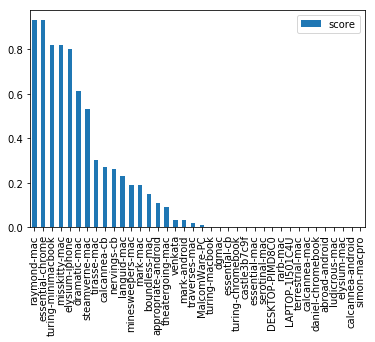

In [48]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()